## Segmentation Model

Here I intend to develop a segmentation model with the aid of previously pre-trained deep neural models. To load the GloVe Embeddings, I followed [this tutorial](https://keras.io/examples/nlp/pretrained_word_embeddings/).

---
### To Do:
- Find a way to best embed numbers

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

from numpy.random import seed
from tensorflow import keras
from tensorflow.keras.layers import (
    TextVectorization, Input, Embedding, LSTM, Bidirectional, TimeDistributed, Dense
)
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Precision, Recall

2021-12-30 19:23:47.746016: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/oracle/instantclient_19_11:
2021-12-30 19:23:47.746042: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
np.random.seed(1996)
tf.random.set_seed(1996)

In [3]:
EMBEDDING_DIM = 100
MIN_TOKENS = 30
MAX_TOKENS = 200
VOCAB_SIZE = 20000
TEST_PCT = 0.15

def get_sentence_labels(text):
    """
        This function gets the label for each word on the sentences
    """
    global MAX_TOKENS
    ORDINARY_TOKEN = 0
    END_OF_SENTENCE_TOKEN = 1
    
    labels = []
    sentences = text.split('.')
    for i, sentence in enumerate(sentences, start=1):
        n_words = len(sentence.split())

        if (sentence == ''):
            continue

        partial_labels = [ORDINARY_TOKEN] * n_words

        if (i != len(sentences)):
            partial_labels[-1] = END_OF_SENTENCE_TOKEN

        labels += partial_labels
    
    n_paddings = MAX_TOKENS - len(labels)
    labels += [0] * n_paddings
    
    return labels
    

def build_random_sized_sentences(text):
    """
        Build random sized sentences out of a single corpus per function call
    """
    global MIN_TOKENS
    global MAX_TOKENS
    
    text_tokens = text.split()
    prev_index = 0
    sentences = []
    while prev_index < len(text_tokens):
        final_index = prev_index + np.random.randint(MIN_TOKENS, MAX_TOKENS)
        sentences.append(' '.join(text_tokens[prev_index:final_index]))
        
        prev_index = final_index
        
    return np.array(sentences)

---
## Training sentences

The training sentences are built by drawing random sentence sizes, and sequentially slicing the original corpora

In [4]:
df = pd.read_csv("../data/TED_Talks/02_preprocessed/subtitles_preprocessed.csv")
df.head(3)

,subtitle,url
0,this is the air jordan number black cement. th...,https://www.ted.com/talks/josh_luber_why_sneak...
1,if you want to buy high quality low price coca...,https://www.ted.com/talks/jamie_bartlett_how_t...
2,do you know how many choices you make in a typ...,https://www.ted.com/talks/sheena_iyengar_how_t...


In [5]:
entire_corpora = df.subtitle.apply(lambda text: build_random_sized_sentences(text))
entire_corpora = np.concatenate(entire_corpora.values)

In [6]:
corpus_size = len(entire_corpora)
train_upper_idx = int(corpus_size * (1 - TEST_PCT))

X_train = entire_corpora[:train_upper_idx]
Y_train = np.array([get_sentence_labels(text) for text in X_train])

X_test = entire_corpora[train_upper_idx:]
Y_test = np.array([get_sentence_labels(text) for text in X_test])

---
## Text Vectorization

In [7]:
vectorizer = TextVectorization(max_tokens=VOCAB_SIZE, output_sequence_length=MAX_TOKENS)
text_ds = tf.data.Dataset.from_tensor_slices(X_train).batch(128)

2021-12-30 19:23:52.981220: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-12-30 19:23:52.981237: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kunumi): /proc/driver/nvidia/version does not exist
2021-12-30 19:23:52.981406: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Learn the most frequent words on the `train_data`

In [8]:
vectorizer.adapt(text_ds)

Build a mapper from words to their respective indices

In [9]:
word_index = {word: i for i, word in enumerate(vectorizer.get_vocabulary())}

---

## Build the Embedding Layer

In [10]:
embeddings = {}
with open(f"../data/embeddings/glove/glove.6B.{EMBEDDING_DIM}d.txt") as file:
    for line in file:
        word, coefs = line.split(maxsplit=1)
        embeddings[word] = np.fromstring(coefs, 'f', sep=' ')

Build the embedding matrix

In [11]:
hits, misses = 0, 0

# +2 due to empty string and UKN token
embedding_matrix = np.zeros((VOCAB_SIZE+2, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 12504 words (309 misses)


In [12]:
model = Sequential()

model.add(
    Embedding(
        VOCAB_SIZE+2,
        EMBEDDING_DIM,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        trainable=False,
        input_shape=(200,)
    )
)

model.add(
    Bidirectional(
        LSTM(
            units=15,
            return_sequences=True
        )
    )
)

model.add(
    TimeDistributed(
        Dense(1, activation='sigmoid')
    )
)

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=BinaryCrossentropy(),
    metrics=[
        Precision(),
        Recall()
    ]
)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 100)          2000200   
                                                                 
 bidirectional (Bidirectiona  (None, 200, 30)          13920     
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 200, 1)           31        
 ibuted)                                                         
                                                                 
Total params: 2,014,151
Trainable params: 13,951
Non-trainable params: 2,000,200
_________________________________________________________________


In [14]:
X_train = vectorizer(X_train)
model.fit(X_train, Y_train, batch_size=256, epochs=100, validation_split=0.1)

Epoch 1/100
259/259 [==============================] - 35s 125ms/step - loss: 0.1998 - precision: 0.0791 - recall: 0.0052 - val_loss: 0.1194 - val_precision: 0.2222 - val_recall: 4.2236e-05
Epoch 2/100
259/259 [==============================] - 34s 131ms/step - loss: 0.1214 - precision: 0.4499 - recall: 0.0012 - val_loss: 0.1021 - val_precision: 0.4363 - val_recall: 0.0024
Epoch 3/100
259/259 [==============================] - 34s 131ms/step - loss: 0.1033 - precision: 0.5768 - recall: 0.0415 - val_loss: 0.0903 - val_precision: 0.5815 - val_recall: 0.0917
Epoch 4/100
259/259 [==============================] - 34s 132ms/step - loss: 0.0928 - precision: 0.6136 - recall: 0.1475 - val_loss: 0.0843 - val_precision: 0.5505 - val_recall: 0.1850
Epoch 5/100
259/259 [==============================] - 34s 131ms/step - loss: 0.0862 - precision: 0.6395 - recall: 0.2380 - val_loss: 0.0808 - val_precision: 0.5574 - val_recall: 0.2479
Epoch 6/100
259/259 [==============================] - 34s 131ms/s

Epoch 45/100
259/259 [==============================] - 41s 158ms/step - loss: 0.0326 - precision: 0.8890 - recall: 0.8165 - val_loss: 0.1227 - val_precision: 0.4674 - val_recall: 0.4454
Epoch 46/100
259/259 [==============================] - 41s 157ms/step - loss: 0.0323 - precision: 0.8907 - recall: 0.8199 - val_loss: 0.1250 - val_precision: 0.4616 - val_recall: 0.4381
Epoch 47/100
259/259 [==============================] - 39s 152ms/step - loss: 0.0319 - precision: 0.8923 - recall: 0.8226 - val_loss: 0.1257 - val_precision: 0.4645 - val_recall: 0.4597
Epoch 48/100
259/259 [==============================] - 40s 156ms/step - loss: 0.0316 - precision: 0.8940 - recall: 0.8262 - val_loss: 0.1273 - val_precision: 0.4692 - val_recall: 0.4486
Epoch 49/100
259/259 [==============================] - 39s 151ms/step - loss: 0.0312 - precision: 0.8956 - recall: 0.8290 - val_loss: 0.1282 - val_precision: 0.4708 - val_recall: 0.4536
Epoch 50/100
259/259 [==============================] - 39s 149ms

Epoch 89/100
259/259 [==============================] - 33s 128ms/step - loss: 0.0240 - precision: 0.9275 - recall: 0.8851 - val_loss: 0.1617 - val_precision: 0.4520 - val_recall: 0.4521
Epoch 90/100
259/259 [==============================] - 33s 127ms/step - loss: 0.0239 - precision: 0.9283 - recall: 0.8857 - val_loss: 0.1617 - val_precision: 0.4498 - val_recall: 0.4469
Epoch 91/100
259/259 [==============================] - 33s 127ms/step - loss: 0.0238 - precision: 0.9283 - recall: 0.8863 - val_loss: 0.1621 - val_precision: 0.4488 - val_recall: 0.4571
Epoch 92/100
259/259 [==============================] - 33s 127ms/step - loss: 0.0237 - precision: 0.9290 - recall: 0.8876 - val_loss: 0.1636 - val_precision: 0.4529 - val_recall: 0.4545
Epoch 93/100
259/259 [==============================] - 34s 129ms/step - loss: 0.0236 - precision: 0.9295 - recall: 0.8884 - val_loss: 0.1638 - val_precision: 0.4479 - val_recall: 0.4606
Epoch 94/100
259/259 [==============================] - 33s 129ms

## Model Performance

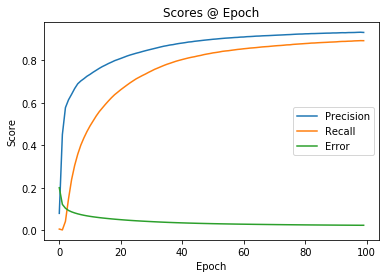

In [26]:
plt.plot(range(100), model.history.history["precision"], label="Precision")
plt.plot(range(100), model.history.history["recall"], label="Recall")
plt.plot(range(100), model.history.history["loss"], label="Error")

plt.legend()
plt.title("Scores @ Epoch")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.show()

In [28]:
X_test[0]

'understanding of who we are where weve come from and the times we live in. during the numberth century we witnessed the atrocities of stalin hitler mao pol pot rwanda and other genocides and even though the numberst century is only seven years old we have already witnessed an ongoing genocide in darfur and the daily horrors of iraq. this has led to a common understanding of our situation namely that modernity has brought us terrible violence and perhaps that native peoples lived in a state of harmony that we have departed from to our peril. here is an example from an op ed on thanksgiving in the boston globe a couple of years ago where the writer wrote the indian life was a difficult one but'

In [29]:
Y_test[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [42]:
pred = model.predict(np.array([vectorizer(X_test[0])])).reshape(1,-1)
pred = (pred > 0.5).astype(int)

In [43]:
pred

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]])